In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import time
import itertools
import os
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from IPython import display

from Functions import RNN, rnn_batch_sorter, colours, monitor_gpu, single_blog_graph, bootstrap_rnn_data, \
                        lag_creator, lin_scale, mse, rnn_bootstrap_batch_sorter

% matplotlib inline

Read in the US quarterly consumer price data

In [23]:
"""
Data from the FED: https://fred.stlouisfed.org/series/CPIAUCSL and stored in github repository for easy access
"""
us_data = pd.read_csv('us_macro_quarterly.csv', index_col = 0)

cpi = us_data['CPIAUCSL']
dates = us_data.index

# Put the data in percentage form
cpi_change = np.zeros([len(cpi)-1, 1])
for i in range(len(cpi)):
    if i != len(cpi)-1:
        change = ((cpi[i+1] - cpi[i])/cpi[i])*100
        cpi_change[i] = change
        
# Create 3 lags to use as features
cpi_targets, cpi_features = lag_creator(np.squeeze(cpi_change), 3)

cpi_targets = lin_scale(cpi_targets)
cpi_features = lin_scale(cpi_features)

Read in the volatility data

In [27]:
"""
Data from Oxford Man Realized Volatility Institute - http://realized.oxford-man.ox.ac.uk/data
In folder "volatility_data" in github repository for easy reproduction of results.
"""

v_tr_features = np.array(pd.read_csv('volatility_data/train_features_data.csv', index_col = 0))
v_tr_targets = np.array(pd.read_csv('volatility_data/train_targets_data.csv', index_col = 0))
v_t_features = np.array(pd.read_csv('volatility_data/test_features_data.csv', index_col = 0))
v_t_targets = np.array(pd.read_csv('volatility_data/test_targets_data.csv', index_col = 0))

Fit a single RNN

In [6]:
num_steps = 5

iter_dict = rnn_batch_sorter(cpi_features, cpi_targets, batch_size = 10, num_steps = num_steps)

start_time = time.time()

# Run the neural net to predict the mean and variance
tf.reset_default_graph()
#with tf.device('/cpu:0'):
with tf.Session() as sess:
    single_rnn = RNN(sess, iter_dict, num_steps = num_steps, num_layers = 1, hidden_size = 10, learning_rate = 0.1, 
                activation_fn = tf.nn.tanh, pass_state = True, cell_type = 'basic')
    single_rnn.train(num_steps = 10000, viz_every = 500)

total_time = time.time() - start_time

print "\nTime: {:.2f} seconds".format(total_time)

Train data: 157 observations
Val data: 33 observations
Test data: 34 observations

3 train feature batches created, of shape (10, 5, 3) [batch_length * num_steps * num_features]
3 train target batches created, in of shape (10, 5, 1) [batch_length * num_steps * num_targets]

7 val feature batches created, of shape (1, 5, 3) [batch_length * num_steps * num_features]
7 val target batches created, in of shape (1, 5, 1) [batch_length * num_steps * num_targets]

7 test feature batches created, of shape (1, 5, 3) [batch_length * num_steps * num_features]
7 test target batches created, in of shape (1, 5, 1) [batch_length * num_steps * num_targets]

32 train_inference feature batches created, of shape (1, 5, 3) [batch_length * num_steps * num_features]
32 train_inference target batches created, in of shape (1, 5, 1) [batch_length * num_steps * num_targets]

Step: 0, Train Loss: 0.0901, Val Loss: 0.0533
Step: 500, Train Loss: 0.0073, Val Loss: 0.0027
Step: 1000, Train Loss: 0.0067, Val Loss: 0.0

Implementation of a basic rnn cell for training multiple networks at once

In [7]:
class boot_BasicRNNCell(tf.contrib.rnn.RNNCell):
    """The most basic RNN cell -  bootstrap version"""

    def __init__(self, num_units, input_size, num_networks, name, activation_fn=tf.nn.tanh):
        self._num_units = num_units
        self._input_size = input_size
        self._num_networks = num_networks
        self._name = name
        self._activation_fn = activation_fn

    @property
    def state_size(self):
        return self._num_units

    @property
    def output_size(self):
        return self._num_units

    def __call__(self, inputs, state, scope=None):
        
        inputs = tf.reshape(inputs, [self._num_networks, -1, self._input_size])
        state = tf.reshape(state, [self._num_networks, -1, self._num_units])
        
        input_weights = tf.get_variable(name = 'input_weights_' + self._name, shape = [self._num_networks, self._input_size, self._num_units],
                                                    initializer = tf.truncated_normal_initializer(stddev = 0.2) )

        state_weights = tf.get_variable(name = 'state_weights_' + self._name, shape = [self._num_networks, self._num_units, self._num_units],
                                            initializer = tf.truncated_normal_initializer(stddev = 0.2))
        bias = tf.get_variable(name = 'bias_' + self._name, shape = [self._num_networks, 1, self._num_units], 
                             initializer = tf.random_uniform_initializer(minval = 0.0, maxval = 1.0))

        inner = tf.matmul(inputs, input_weights) + tf.matmul(state, state_weights) + bias

        # output will be dimensions [num_networks, batch_size, num_units]
        output = self._activation_fn(inner)
        
        # change output to 2D: [num_networks * batch_size, num_units]
        output = tf.reshape(output, [-1, self._num_units])

        return output, output

Implementation of GRU cell for training multiple networks at once

In [8]:
class boot_GRUCell(tf.contrib.rnn.RNNCell):
    """Gated Recurrent Unit cell (cf. http://arxiv.org/abs/1406.1078)."""

    def __init__(self, num_units, input_size, num_networks, name, activation_fn = tf.nn.tanh):
        self._num_units = num_units
        self._input_size = input_size
        self._activation_fn = activation_fn
        self._num_networks = num_networks
        self._name = name

    @property
    def state_size(self):
        return self._num_units

    @property
    def output_size(self):
        return self._num_units

    def __call__(self, inputs, state, scope=None):
        """Gated recurrent unit (GRU) with num_units cells - bootstrapped version."""
        
        # Reshape inputs to [num_networks, batch_size, input_size]
        inputs = tf.reshape(inputs, [self._num_networks, -1, self._input_size])
        # Reshape state to [num_networks, batch_size, num_units]
        state = tf.reshape(state, [self._num_networks, -1, self._num_units])
        
        # Update gate
        up_input_weights = tf.get_variable(name = 'update_input_weights_' + self._name, shape = [self._num_networks, self._input_size, self._num_units],
                                                    initializer = tf.truncated_normal_initializer(stddev = 0.2) )
        up_state_weights = tf.get_variable(name = 'update_state_weights_' + self._name, shape = [self._num_networks, self._num_units, self._num_units],
                                            initializer = tf.truncated_normal_initializer(stddev = 0.2))
        up_bias = tf.get_variable(name = 'update_bias_' + self._name, shape = [self._num_networks, 1, self._num_units], 
                             initializer = tf.constant_initializer(1.0))
        
        update_gate = tf.sigmoid(tf.matmul(inputs, up_input_weights) + tf.matmul(state, up_state_weights) + up_bias)

        # Reset gate
        reset_input_weights = tf.get_variable(name = 'reset_input_weights_' + self._name, shape = [self._num_networks, self._input_size, self._num_units],
                                                    initializer = tf.truncated_normal_initializer(stddev = 0.2) )
        reset_state_weights = tf.get_variable(name = 'reset_state_weights_' + self._name, shape = [self._num_networks, self._num_units, self._num_units],
                                            initializer = tf.truncated_normal_initializer(stddev = 0.2))
        reset_bias = tf.get_variable(name = 'reset_bias_' + self._name, shape = [self._num_networks, 1, self._num_units], 
                             initializer = tf.constant_initializer(1.0))
        
        reset_gate = tf.sigmoid(tf.matmul(inputs, reset_input_weights) + tf.matmul(state, reset_state_weights) + reset_bias)
        
        # Output/hidden state update
        h_input_weights = tf.get_variable(name = 'h_input_weights_' + self._name, shape = [self._num_networks, self._input_size, self._num_units],
                                                    initializer = tf.truncated_normal_initializer(stddev = 0.2) )
        h_state_weights = tf.get_variable(name = 'h_state_weights_' + self._name, shape = [self._num_networks, self._num_units, self._num_units],
                                            initializer = tf.truncated_normal_initializer(stddev = 0.2))
        h_bias = tf.get_variable(name = 'h_bias_' + self._name, shape = [self._num_networks, 1, self._num_units], 
                             initializer = tf.constant_initializer(1.0))
        
        h = self._activation_fn(tf.matmul(inputs, h_input_weights) + tf.matmul(state * reset_gate, h_state_weights) + h_bias)
        
        output = update_gate * state + (1 - update_gate) * h
        
        # change output to 2D: [num_networks * batch_size, num_units]
        output = tf.reshape(output, [-1, self._num_units])
        
        return output, output


The RNN network for training multiple small networks at once

In [9]:
class bootstrap_RNN(object):
    
    def __init__(self, sess, batch_iterators, num_steps, num_layers = 1, hidden_size = 10, cell_type = 'basic',
                 activation_fn = tf.nn.tanh, learning_rate = 0.00001, pass_state = False, num_networks = 100,
                  model_name = 'rnn', checkpoint_dir = 'rnn_checkpoint', average_drop = 0.1):
        
        self.sess = sess  # a Tensorflow session
        
        # Data iterators - hold the data sets, and return the next batch when next_batch() called
        self.train_iter = batch_iterators['train'] # Training data
        self.test_iter = batch_iterators['test'] # Test data - batch length of 1, and no masking
        self.train_inf_iter = batch_iterators['tr_inf'] # Train data for predictions at end - batch size of 1 and no masking
        self.train_loss_iter = batch_iterators['tr_loss'] # Train data for checking val/train loss during training
                                                          # Batch length of 1, and masking of val/train data if needed
        
        self.num_steps = num_steps # how many steps to unroll the RNN during training
        self.num_layers = num_layers # number of layers of the RNN
        self.hidden_size = hidden_size # the number of units in each RNN cell
        self.cell_type = cell_type # one of ['basic', 'gru] - which RNN cell to use
        self.activation_fn = activation_fn # activation function used in the RNN cells
        
        self.learning_rate = learning_rate # the learning rate for training
        self.pass_state = pass_state # whether to pass state on from last batch in epoch to first batch during training

        self.num_networks = num_networks # how many networks we're training at the same time
                
        self.model_name = model_name # Name for the model - used in name of saved checkpoint files
        self.checkpoint_dir = checkpoint_dir # Directory in which to save checkpoint files
        
        self.targets_dim = self.train_iter.targets_dim # dimension of the target variable
        self.features_dim = self.train_iter.features_dim # number of features 

        self.average_drop = average_drop # the ratio of networks to drop with the worst val losses when calculating
                                         # the average prediction of all networks at the end
                
        # Lists to keep track of which epoch each separate network achieves its best val error in
        self.best_step = [0] * self.num_networks
        self.best_val_losses = [float('inf')] * self.num_networks
    
        self.build_model()
                
        self.saver = tf.train.Saver()
        
    def build_model(self):
        
        # Placeholders
        self.features_pl = tf.placeholder(tf.float32, [None, self.num_steps, self.features_dim], 'features_pl')
        self.targets_pl = tf.placeholder(tf.float32, [None, self.num_steps, self.targets_dim], 'targets_pl')
        self.mask_pl = tf.placeholder(tf.float32, [self.num_networks, None, self.num_steps, 1], 'mask_pl')
        self.seq_len_pl = tf.placeholder(tf.int32, shape = [None], name = 'seq_len_pl')
        self.b_size_pl = tf.placeholder(tf.int32, shape = (), name = 'b_size_pl')
        
        # Tile features and targets - one for each network trained concurrently
        self.all_features = tf.tile(tf.expand_dims(self.features_pl, axis = 0), [self.num_networks, 1, 1, 1])
        targets_tiled = tf.tile(tf.expand_dims(self.targets_pl, axis = 0), [self.num_networks, 1, 1, 1])
        
        # Reshape targets and mask to match the output shape of the RNN
        targets = tf.concat(tf.unstack(targets_tiled, num = self.num_steps, axis = 2), axis = 1)
        self.targets = targets[:, :self.b_size_pl, :]
        mask = tf.concat(tf.unstack(self.mask_pl, num = self.num_steps, axis = 2), axis = 1)
        self.mask = mask[:, :self.b_size_pl, :]
        
        # Unstack features into num_step length list of [num_boot, batch_size, features_dim] tensors to feed to RNN
        self.features_mat = tf.unstack(self.all_features, num = self.num_steps, axis = 2)
        self.features = [tf.reshape(t, [-1, self.features_dim]) for t in self.features_mat]
        
        # Create the cells and state placeholders for each layer 
        cells = []
        self.initial_state_list = []
        for l in range(self.num_layers):
            if l == 0:
                in_size = self.features_dim
            else:
                in_size = self.hidden_size
            
            if self.cell_type == 'gru':
                cells.append(boot_GRUCell(self.hidden_size, input_size = in_size, num_networks = self.num_networks,
                                       name = str(l), activation_fn = self.activation_fn))
            elif self.cell_type == 'basic':
                cells.append(boot_BasicRNNCell(self.hidden_size, input_size = in_size, num_networks = self.num_networks,
                                       name = str(l), activation_fn = self.activation_fn))
                
            self.initial_state_list.append(tf.placeholder(tf.float32, [None, self.hidden_size], name = 'init_state_pl_'+ str(l)))            
        
        # Set up the RNN
        multi_cell = tf.contrib.rnn.MultiRNNCell(cells, state_is_tuple = True)
        
        self.cell_outputs, self.final_state  = tf.contrib.rnn.static_rnn(multi_cell, self.features, 
                                initial_state = tuple(self.initial_state_list), sequence_length = self.seq_len_pl)
        
        # Reshape outputs to a length num_steps list, of [num_bootstraps, batch_size, hidden_size] tensors
        outputs = [tf.reshape(c, [self.num_networks, -1, self.hidden_size]) for c in self.cell_outputs]
        
        # Join the elements of the list, giving shape of [num_bootstraps, batch_size * num_steps, hidden_size]
        joined_outputs = tf.concat(outputs, axis = 1)[:, :self.b_size_pl, :]

        # Output fully connected layer
        output_weights = tf.get_variable(name = "output_weights", shape = [self.num_networks, self.hidden_size, self.targets_dim], 
                                         initializer = tf.truncated_normal_initializer(stddev = 0.2))
        output_bias = tf.get_variable(name = "output_bias", shape = [self.num_networks,1, self.targets_dim],
                                      initializer = tf.random_uniform_initializer(minval = 0.0, maxval = 1.0))      
        self.output = tf.matmul(joined_outputs, output_weights) + output_bias        
                
        # Calculate the loss, masking out val data during training
        masked_difference = (self.targets - self.output) * self.mask
        self.loss = tf.reduce_sum(tf.pow(masked_difference, 2))/tf.reduce_sum(self.mask)
        
        # Create separate loss functions - these will not be used for training as faster with one loss op, but will
        # be used at eval stage. Also need to return a weighting for each batch based on num of non zero points in it
        self.loss_list = []
        # Conditional statement to handle cases where all weightings in a batch are zero
        for b in range(self.num_networks):
            sum_mask = tf.reduce_sum(self.mask[b,:,:])
            def f1(): return (tf.constant(0, dtype = tf.float32),tf.constant(0, dtype = tf.float32))
            def f2(): 
                masked_diff = (self.targets[b,:,:] - self.output[b,:,:]) * self.mask[b,:,:]
                return (tf.reduce_sum(tf.pow(masked_diff, 2))/sum_mask, sum_mask)
            cond = tf.cond(tf.equal(tf.constant(0, dtype = tf.float32), sum_mask), f1, f2)
            self.loss_list.append(cond)
            
        # Optimizer
        self.opt = tf.train.GradientDescentOptimizer(self.learning_rate)
        grads_and_vars = self.opt.compute_gradients(self.loss)
        
        # Scale the gradients by the number of bootstraps
        new_grads_and_vars =[(g*self.num_networks, v) for g, v in grads_and_vars]
        self.optimizer = self.opt.apply_gradients(new_grads_and_vars)
                
        # Trainable vars
        self.trainable_vars = tf.trainable_variables()

    def train(self, viz_every = 500, num_steps = 5000):
        """
        Train the network and calculate the final predictions/loss for all datasets
        """
        
        best_val_loss = float('inf')
        self.sess.run(tf.global_variables_initializer())
                
        for step in xrange(num_steps):
            
            # Fill numpy version of state for next batch
            if step == 0:
                state = self.fill_zero_state(self.train_iter)
   
            if self.train_iter.counter == 0:
                if self.pass_state:
                    state = self.update_train_state(state)
                else:
                    state = self.fill_zero_state(self.train_iter)
                    
            # Get next batch
            f_batch, t_batch, seq_len, mask = self.train_iter.next_batch()
            b_size = int(np.sum(seq_len))
            
            # Fill the feed_dict
            feed_dict = {self.features_pl: f_batch, self.targets_pl: t_batch, 
                         self.seq_len_pl: seq_len, self.b_size_pl: b_size, self.mask_pl: mask}
            for l in range(self.num_layers):
                feed_dict[self.initial_state_list[l]] = state[l]
                        
            # Run a training step
            ops = {"opt": self.optimizer, "final_state": self.final_state}         
            returns = self.sess.run(ops, feed_dict = feed_dict)
            
            # Pass final state of previous batch onto next batch
            state = returns["final_state"]
            
            if step % viz_every == 0:
                # Check progress
                _, TRAIN_LOSSES, _ = self.run_data_set(self.train_loss_iter)
                _, VAL_LOSSES, _ = self.run_data_set(self.train_loss_iter, invert = True)
                print "Step: {0}, Train Loss: {1:.4f}, Val Loss: {2:.4f}".format(step,np.average(TRAIN_LOSSES),
                                                                                 np.average(VAL_LOSSES))                                
                
                # Update the best val losses if any of the networks beat their best val loss so far
                save_update = False
                for b in range(self.num_networks):
                    if VAL_LOSSES[b] < self.best_val_losses[b]:
                        self.best_val_losses[b] = VAL_LOSSES[b]
                        self.best_step[b] = step
                        save_update = True

                # Save if any of the separate bootstrapped networks have improved on their best val loss
                if save_update:                    
                    T_VARS = self.sess.run(self.trainable_vars)
                    self.update_t_vars(T_VARS, step = step)
        
        # Restore the best variables for each network from numpy versions
        self.restore_best_vars()
        
        # Run final predictions and losses
        self.TRAIN_PREDS, self.ALL_TRAIN_LOSSES, tr_state = self.run_data_set(self.train_inf_iter)
        _, self.TRAIN_LOSSES, _= self.run_data_set(self.train_loss_iter)
        _, self.VAL_LOSSES, _= self.run_data_set(self.train_loss_iter, invert = True)
        self.TEST_PREDS, self.TEST_LOSSES, _ = self.run_data_set(self.test_iter, previous_state = tr_state)
        
        # Calculate the average prediction, and associated loss
        self.average_preds()
        
        print "Final Losses, Train: {1:.4f}, Val: {2:.4f}, Test: {3:.4f}".format(step, np.average(self.TRAIN_LOSSES), 
                                                            np.average(self.VAL_LOSSES), np.average(self.TEST_LOSSES)) 
        
                                
    def run_data_set(self, iterator, previous_state = None, invert = False):
        """
        Runs a full data set, returning the predictions and average loss for the whole 
        dataset, for each bootstrap network individually
        """
        
        # Store starting value of iterator to return to
        counter_start = iterator.counter
        # Start from the first batch
        iterator.counter = 0
        
        # Dicts of lists for storing preds and loss for each network
        preds_dict = {}
        loss_dict = {}
        for b in range(self.num_networks):
            preds_dict[b] = []
            loss_dict[b] = []    
            
        # Numpy version of state
        if previous_state == None:
            state = self.fill_zero_state(iterator)
        else:
            state = previous_state
                
        for step in xrange(iterator.num_batches):
            
            f_batch, t_batch, seq_len, mask = iterator.next_batch()
            b_size = int(np.sum(seq_len))
            if invert:
                mask = (mask == 0) * 1

                
            # Fill the feed_dict
            feed_dict = {self.features_pl: f_batch, self.targets_pl: t_batch, 
                         self.seq_len_pl:seq_len, self.b_size_pl: b_size, self.mask_pl:mask}
            
            for l in range(self.num_layers):
                feed_dict[self.initial_state_list[l]] = state[l]
            
            # Define which ops to run and run the session
            ops = {"final_state": self.final_state, "losses": self.loss_list,
                   "preds": self.output}           
            returns = self.sess.run(ops, feed_dict = feed_dict)
            
            # Pass final state onto next batch
            state = returns["final_state"]
            
            # Store individual results for each network
            for b in range(self.num_networks):
                preds_dict[b].append(returns["preds"][b, :, :])
                loss_dict[b].append(returns["losses"][b])
        
        # Combine predictions across all batches and average losses
        all_preds_list = []
        average_loss_list = []
        
        for b in range(self.num_networks):
            all_preds_list.append(np.concatenate(preds_dict[b], axis = 0))
            l_and_w = [np.array(i) for i in zip(*loss_dict[b])]
            average_loss_list.append(np.average(l_and_w[0], weights = l_and_w[1]))

        # Return iterator counter to starting value
        iterator.counter = counter_start
        
        return all_preds_list, average_loss_list, state
   
    def save(self, key = None):
        """
        Saves a checkpoint file
        key: name to add to the checkpoint filenames
        """
        if not os.path.exists(self.checkpoint_dir):
            os.makedirs(self.checkpoint_dir)
        if key:
            self.saver.save(self.sess, self.checkpoint_dir + '/' + self.model_name + '-' + str(key))        
        
    def fill_zero_state(self, iter_):  
        """
        Returns state filled with zeros for start of training/eval
        iter_: data iterator
        """
        state = []
        for l in range(self.num_layers):
            state.append(np.zeros([self.num_networks * iter_.batch_size, self.hidden_size]))
        return state

    def update_train_state(self, prev_state):
        """
        Takes the state from last training batch in epoch and shifts it down by one row, so 
        that correct state is passed to the first training batch in the next epoch
        prev_state: the state from the final batch of the previous epoch
        """
        old_state = list(prev_state)
        new_state = []
        for l in range(self.num_layers):
            s = np.reshape(old_state[l], [self.num_networks, -1, self.hidden_size])
            new_s = np.concatenate([np.zeros([self.num_networks, 1, self.hidden_size], 
                                dtype = np.float64), s], axis = 1)[:,:-1,:]
            new_state.append(np.reshape(new_s, [-1, self.hidden_size]))        
        return tuple(new_state)
    
    def update_t_vars(self, current_vars, step):
        """
        Updates the numpy version of the variables if any of the individual networks beat their best val loss
        current_vars: the numpy variable values from the current train step
        step: how many steps of training have been carried out so far
        """
        if not hasattr(self, 'best_vars'):            
            self.best_vars = [np.zeros_like(v) for v in current_vars]
        
        # If loss was lowest for this bootstrap with these variables, update our new best variables
        for b in range(self.num_networks):
            if self.best_step[b] == step:
                # Assign the correct parts of these variables to our new var list
                for num, v in enumerate(self.best_vars):
                    v[b] = current_vars[num][b]      

    def restore_best_vars(self, save = True):
        """
        Restores the variable values from the epoch in which each network achieved its lowest val loss
        save: whether or not to save a checkpoint file after the variables have been restored
        """
        # Assign the new vars which we have created to the variables in the original graph
        all_assign_ops = [v.assign(self.best_vars[num]) for num, v in enumerate(self.trainable_vars)]
        self.sess.run(all_assign_ops)
        
        if save:
            # Save the new combined best variables and delete the null old checkpoints
            self.save(key = 'best')

    def average_preds(self):
        """
        Adds the average predictions of all the networks as an attribute to self, and calculates the loss associated
        with this average prediction. Drops percentage self.average_drop of the worst networks before doing this
        """
        if not hasattr(self, 'TRAIN_PREDS'):
            raise Exception('Need to train the network first')
        
        num_to_drop = int(self.num_networks * self.average_drop)
        best_indices = list(np.array(self.ALL_TRAIN_LOSSES).argsort()[:(len(self.ALL_TRAIN_LOSSES) - num_to_drop)])
        
        self.av_train_preds = np.average([self.TRAIN_PREDS[i] for i in best_indices], axis = 0)
        self.av_test_preds = np.average([self.TEST_PREDS[i] for i in best_indices], axis = 0)
        self.av_train_loss = np.average((self.train_inf_iter.all_targets()[:len(self.av_train_preds)] - self.av_train_preds)**2)
        self.av_test_loss = np.average((self.test_iter.all_targets()[:len(self.av_test_preds)] - self.av_test_preds)**2)
        print "Average Test Loss: {:.4f}".format(self.av_test_loss) 

Function for running timed experiments

In [16]:
def time_network(bootstraps_list = [1, 2], iterations = 1, num_steps = 5, hidden_size = 10, min_batch_size = 10):
    
    time_df = pd.DataFrame(columns = ['CPU', 'GPU'], index = bootstraps_list)
    average_time_df = pd.DataFrame(columns = ['CPU', 'GPU'], index = bootstraps_list)
    gpu_df = pd.DataFrame(columns = ['GPU % usage'], index = bootstraps_list)
       
    for compute in ['CPU', 'GPU']:
    
        for b in bootstraps_list:
            
            # Put data in iterators 
            iter_dict = rnn_bootstrap_batch_sorter(cpi_features, cpi_targets, min_batch_size = min_batch_size,
                                           num_steps = num_steps, num_networks = b, val_ratio = 0.2)  
            iter_dict_s = rnn_batch_sorter(cpi_features, cpi_targets, batch_size = 10, num_steps = num_steps)
            #iter_dict = bootstrap_rnn_data(v_tr_features, v_tr_targets, v_t_features, v_t_targets, min_batch_size = 30, 
             #          num_steps = 5, num_networks = b, val_ratio = 0.15, method = 'simple_block')
            
            times = []
            gpu_usage = []

            for i in range(iterations):

                tf.reset_default_graph()

                with tf.Session() as sess:

                    start_time = time.time()

                    if compute == 'CPU':
                        with tf.device('/cpu:0'):
                            
                            if b == 1:
                                rnn = RNN(sess, iter_dict_s, num_steps = num_steps, num_layers = 1, learning_rate = 0.1, 
                                            hidden_size = hidden_size, pass_state = False, cell_type = 'basic',
                                         activation_fn = tf.nn.tanh)
                            else:
                                rnn = bootstrap_RNN(sess, iter_dict, num_steps = num_steps, num_networks = b, num_layers = 1, 
                                           hidden_size = hidden_size,  learning_rate = 0.1, activation_fn = tf.nn.tanh, pass_state = False,
                                            cell_type = 'basic')
                            rnn.train(num_steps = 10000, viz_every = 500)
                            
                            
                    elif compute == 'GPU':
                        
                        if b == 1:
                            rnn = RNN(sess, iter_dict_s, num_steps = num_steps, num_layers = 1, learning_rate = 0.1, 
                                           hidden_size = hidden_size, pass_state = False, cell_type = 'basic',
                                         activation_fn = tf.nn.tanh)
                        else:
                            rnn = bootstrap_RNN(sess, iter_dict, num_steps = num_steps, num_networks = b, num_layers = 1, 
                                           hidden_size = hidden_size,  learning_rate = 0.1, activation_fn = tf.nn.tanh, pass_state = False,
                                            cell_type = 'basic')
                        gpu = monitor_gpu()
                        gpu.start_monitoring()
                        rnn.train(num_steps = 10000, viz_every = 500)
                        
                display.clear_output()

                times.append(time.time() - start_time)

                if compute == 'GPU':
                    gpu.stop_monitoring()
                    gpu_usage.append(gpu.average_use)

            time_df.ix[b,compute] = np.round(np.average(times),2)
            average_time_df.ix[b,compute] = np.round(np.average(times)/float(b),2)
            
            if compute == 'GPU':
                gpu_df.ix[b, 0] = np.round(np.average(gpu_usage), 2)
                
    return time_df, average_time_df, gpu_df

Run experiments

In [18]:
time_df, av_time_df, gpu_df = time_network(bootstraps_list = [1,2,5,10,25,50,100,150,200])

In [9]:
time_df_1, av_time_df_1, gpu_df_1 = time_network(bootstraps_list = [1,2,5,10,25,50,100,150,200], hidden_size = 50)

Fit RNNs to CPI data

In [19]:
# Start monitoring gpu activity
gpu = monitor_gpu()
gpu.start_monitoring()

# Network parameters
num_steps = 5
num_bootstraps = 50

# Get the data ready in iterators
iter_dict = rnn_bootstrap_batch_sorter(cpi_features, cpi_targets, min_batch_size = 10, num_steps = num_steps, 
                               num_networks = num_bootstraps, val_ratio = 0.2)

start_time = time.time()

tf.reset_default_graph()

with tf.device('/cpu:0'):
    with tf.Session() as sess:
        rnn = bootstrap_RNN(sess, iter_dict, num_steps = num_steps, num_networks = num_bootstraps, num_layers = 1, 
                           hidden_size = 10,  learning_rate = 0.1, activation_fn = tf.nn.tanh, pass_state = True,
                              cell_type = 'basic')
        rnn.train(num_steps = 10000, viz_every = 500)

total_time = time.time() - start_time
print "\nTime: {:.2f} seconds".format(total_time)

gpu.stop_monitoring()
print '\nGPU average usage: {:.2f}%'.format(gpu.average_use)

Train/ Val data: 190 observations
Test data: 34 observations

3 train features batches created, of shape (12, 5, 3) [batch_length * num_steps * num_features]
3 train targets batches created, of shape (12, 5, 1) [batch_length * num_steps * num_features]
7 test features batches created, of shape (1, 5, 3) [batch_length * num_steps * num_features]
7 test targets batches created, of shape (1, 5, 1) [batch_length * num_steps * num_features]
38 train_inference features batches created, of shape (1, 5, 3) [batch_length * num_steps * num_features]
38 train_inference targets batches created, of shape (1, 5, 1) [batch_length * num_steps * num_features]
Step: 0, Train Loss: 0.0182, Val Loss: 0.0286
Step: 500, Train Loss: 0.0048, Val Loss: 0.0102
Step: 1000, Train Loss: 0.0044, Val Loss: 0.0075
Step: 1500, Train Loss: 0.0040, Val Loss: 0.0059
Step: 2000, Train Loss: 0.0040, Val Loss: 0.0056
Step: 2500, Train Loss: 0.0040, Val Loss: 0.0058
Step: 3000, Train Loss: 0.0038, Val Loss: 0.0052
Step: 3500

Plot the CPI predictions

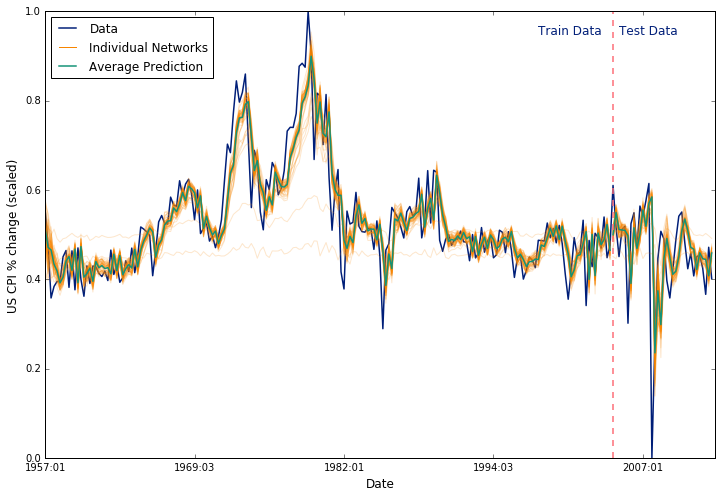

In [20]:
fig = plt.figure(figsize = [12,8])
ax = plt.axes()
ax.plot(np.arange(len(cpi_targets)), cpi_targets, c = colours['dark_blue'], linewidth = 1.5, label = 'Data')
iterator = itertools.cycle(colours.values()[:-1])

tr_len = rnn.TRAIN_PREDS[0].shape[0]
t_len = rnn.TEST_PREDS[0].shape[0]

for b in range(len(rnn.TRAIN_PREDS)):
    c = iterator.next()
    if b == 0:
        ax.plot(np.arange(tr_len), rnn.TRAIN_PREDS[b], c = colours['orange'], alpha = 0.2, label = 'Individual Networks')
    else:
        ax.plot(np.arange(tr_len), rnn.TRAIN_PREDS[b], c = colours['orange'], alpha = 0.2)

    ax.plot(np.arange(t_len) + tr_len, rnn.TEST_PREDS[b], c = colours['orange'], alpha = 0.2)
    
ax.plot(np.arange(tr_len), rnn.av_train_preds, c = colours['green'], linewidth = 1.5, label = 'Average Prediction')
ax.plot(np.arange(t_len) + tr_len, rnn.av_test_preds, c = colours['green'], linewidth = 1.5)
_ = ax.axvline(x = tr_len, c = colours['pink'], linewidth = 1.5, linestyle = 'dashed')
ix = np.array(ax.get_xticks(), dtype = np.int32)
plt.xticks(ix, dates[ix[:-1]])
_ = ax.set_xlim([0, tr_len + t_len])

leg = ax.legend(loc = 'upper left')
leg.legendHandles[1].set_alpha(1)
ax.text(165, 0.95, 'Train Data', fontsize = 12, color = colours['dark_blue'])
ax.text(192, 0.95, 'Test Data', fontsize = 12, color = colours['dark_blue'])

ax.set_xlabel('Date', fontsize = 12)
ax.set_ylabel('US CPI % change (scaled)', fontsize = 12)
#fig.savefig('Pictures/bootstrap.png', dpi = 200)

Fit AR and ARMA models as baseline reference

In [21]:
train_data = rnn.train_inf_iter.all_targets()
test_data = np.squeeze(rnn.test_iter.all_targets())
ar = AR(train_data)
arma = ARMA(train_data, (3, 1))
ar_fit = ar.fit(max_lag = 3)
arma_fit = arma.fit()
ar_predictions = ar_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1, dynamic=False)
arma_predictions = arma_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1, dynamic=False)
ar_mse = mse(test_data, ar_predictions)
arma_mse = mse(test_data, arma_predictions)
print "AR test loss: {:.4f}".format(ar_mse)
print "ARMA test loss: {:.4f}".format(arma_mse)

AR test loss: 0.0243
ARMA test loss: 0.0234
